# MNIST Image Classification with TensorFlow

This notebook demonstrates how to implement a simple linear image model on MNIST data set using `tf.keras`.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tf.__version__)

2.4.1


## Exploring the data

In [5]:
HEIGHT = 28
WIDTH = 28
NCLASSES = 10

# Get MNIST data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale features between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to categorical one-hot encoding
y_train = tf.keras.utils.to_categorical(y=y_train, num_classes=NCLASSES)
y_test = tf.keras.utils.to_categorical(y=y_test, num_classes=NCLASSES)

print("x_train.shape = {}".format(x_train.shape))
print("y_train.shape = {}".format(y_train.shape))
print("x_test.shape = {}".format(x_test.shape))
print("y_test.shape = {}".format(y_test.shape))

x_train.shape = (60000, 28, 28)
y_train.shape = (60000, 10)
x_test.shape = (10000, 28, 28)
y_test.shape = (10000, 10)


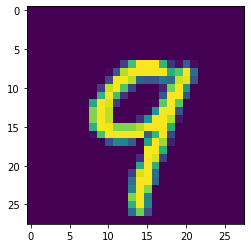

In [7]:
IMGNO = 12
plt.imshow(x_test[IMGNO].reshape(HEIGHT, WIDTH));

## Define the model

Let's start with a very simple linear classifier. All our models will have this basic interface $-$ they will take an image and return probabilities.

In [8]:
# Build Keras model using Keras Sequential API
def linear_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=[HEIGH, WIDTH], name="image"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=NCLASSES, activation=tf.nn.softmax, name="probabilities"))
    return model

## Write input functions

As usual, we need to define input functions for training, test/evaluation, and serving/prediction.

In [9]:
# Create training input function
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": x_train},
    y=y_train,
    batch_size=100,
    num_epochs=None,
    shuffle=True,
    queue_capacity=5000
)

# Create evaluation input function
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": x_test},
    y=y_test,
    batch_size=100,
    num_epochs=1,
    shuffle=False,
    queue_capacity=5000
)

# Create serving input function for inference
def serving_input_fn():
    placeholders = {"image": tf.placeholder(dtype=tf.float32, shape=[None, HEIGHT, WIDTH])}
    features = placeholders # as is
    return tf.estimator.export.ServingInputReceiver(features=features, receiver_tensors=placeholders)

## Create `train_and_evaluate` function

`tf.estimator.train_and_evaluate` carries out the distributed training

In [ ]:
def train_and_evaluate(output_dir, hparams):
    # Build Keras model
    model = linear_model()
    
    # Compile Keras model with optimiser, loss function, and eval metrics
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"])
    
    # Convert Keras model to a tf.estimator.Estimator()
    estimator = tf.keras.estimator.model_to_estimator(
        keras_model=model,
        model_dir=output_dir)
    
    # Set estimator's tf.estimator.TrainSpec() to use train_input_fn and train
    